In [73]:
import torch, os, random
from torch import nn
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import gc
from pathlib import Path
import tensorflow as tf
import utils

In [16]:
pascal_voc_path = os.path.join(os.getcwd(),"data", "pascal_voc")
pascal_voc_path = Path(pascal_voc_path).resolve()
os.listdir(os.path.join(pascal_voc_path, "train", "images"))

['aeroplane',
 'bicycle',
 'bird',
 'boat',
 'bottle',
 'bus',
 'car',
 'cat',
 'chair',
 'cow',
 'diningtable',
 'dog',
 'horse',
 'motorbike',
 'person',
 'pottedplant',
 'sheep',
 'sofa',
 'train',
 'tvmonitor']

In [20]:
selected_class = "horse"
train_path = os.path.join(pascal_voc_path, "train")
val_path = os.path.join(pascal_voc_path, "val")
train_x = os.path.join(train_path, "images", f"{selected_class}")
val_x = os.path.join(val_path, "images", f"{selected_class}")
train_y = os.path.join(train_path, "masks", f"{selected_class}")
val_y = os.path.join(val_path, "masks", f"{selected_class}")

## visualize sample data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


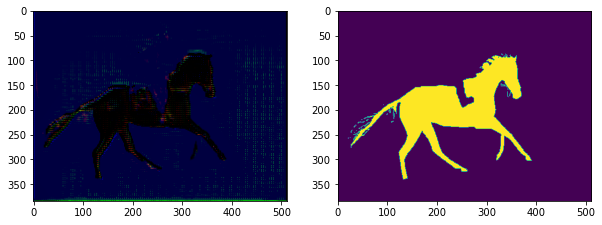

In [21]:
def load_data(path_root, path_list):
    path_list = [path_list] if type(path_list) == str else path_list
    return np.squeeze(np.array([np.load(os.path.join(path_root, i)) for i in path_list]))

temp_paths = os.listdir(train_x)
random.shuffle(temp_paths)
temp_paths = temp_paths[0]
sample_data = load_data(train_x, temp_paths)
sample_data_mask = load_data(train_y, temp_paths)

fig = plt.figure(figsize=(10,8))

fig.add_subplot(1,2,1)
plt.imshow(sample_data[:,:,6:9])
fig.add_subplot(1,2,2)
plt.imshow(sample_data_mask)

In [19]:
img_height, img_width, num_channels = sample_data.shape
device = torch.device("cuda:0")

In [25]:
utils.numpy_to_tensor(sample_data_mask)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [35]:
image = utils.numpy_to_tensor(np.arange(100).reshape(10,10))
image = np.arange(100).reshape(10,10)

#source
#https://www.telesens.co/2018/04/09/initializing-weights-for-the-convolutional-and-fully-connected-layers/

In [63]:
filter_size = 3
stride = 2
image_height , image_width = image.shape
new_width = int((image_width - filter_size)/stride + 1)
new_height = int((image_height - filter_size)/stride + 1)
new_image = np.zeros((new_height*new_width, filter_size**2))
for i in range(new_height):
    for j in range(new_width):
        new_image[i*new_width+j] = image[stride*i:stride*i+filter_size, stride*j:stride*j+filter_size].flatten()        

In [67]:
kernel = np.arange(filter_size**2).reshape(filter_size, filter_size)
kernel

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [71]:
new_image.dot(kernel.flatten()).reshape(new_height, new_width)

array([[ 582.,  654.,  726.,  798.],
       [1302., 1374., 1446., 1518.],
       [2022., 2094., 2166., 2238.],
       [2742., 2814., 2886., 2958.]])

## simple network1 - conv
#### tensorflow-conv

In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-3)

def compute_loss(model, x, masks):
    logits = model(x)
    scce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    scce_loss = scce(masks, logits)
    return scce_loss


@tf.function
def train_step(model, x, masks, optimizer):
    """Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x, masks)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

def calc_iou_per_class(pred_x, targets):
    iou_per_class = []
    for i in range(len(pred_x)):
        pred = np.argmax(pred_x[i].numpy(), -1).astype(int)
        target = targets[i].astype(int)
        iou = np.sum(np.logical_and(target, pred))/np.sum(np.logical_or(target, pred))
        iou_per_class.append(iou)
        mean_iou_per_class = np.mean(iou_per_class)
    return mean_iou_per_class

In [ ]:
conv1 = tf.keras.layers.Conv2D(filters=2, kernel_size=4, strides=1, padding='same',\
                               activation="relu", use_bias=False)
inputs = tf.keras.Input(shape=(img_height, img_width, num_channels))
output = conv1(inputs)
seg_net = tf.keras.Model(inputs=inputs, outputs=output)
seg_net.summary()

In [ ]:
tf.keras.backend.clear_session()
epochs = 30
bs = 10
learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate)
losses = []
train_x_paths = os.listdir(train_x)
val_x_paths = os.listdir(val_x)
for i in range(epochs):
    random.shuffle(train_x_paths)
    batch_losses = []
    iou_per_class = []
    iou_per_class_val = []
    len_paths = []
    for j in range(len(train_x_paths)//bs + 1):
        batch_paths = train_x_paths[j*bs: (j+1)*bs]
        len_paths.extend(batch_paths)
        batch_x = load_data(train_x, batch_paths)
        batch_y = load_data(train_y, batch_paths)
        loss = train_step(seg_net, batch_x, batch_y, optimizer)
        batch_losses.append(loss.numpy())
        pred_x = seg_net(batch_x)
        iou_per_class.append(calc_iou_per_class(pred_x, batch_y))
        batch_losses.append(loss)
    for j in range(len(val_x_paths)//bs + 1):
        batch_paths = val_x_paths[j*bs: (j+1)*bs]
        batch_x_val = load_data(val_x, batch_paths)
        batch_y_val = load_data(val_y, batch_paths)
        pred_x_val = seg_net(batch_x_val)
        iou_per_class_val.append(calc_iou_per_class(pred_x_val, batch_y_val))
    loss = sum(batch_losses)
    iou = np.mean(np.array(iou_per_class))
    iou_val = np.mean(np.array(iou_per_class_val))
    losses.append(loss)
    print(f"epoch {i}, loss: {loss}, iou_train: {iou}, iou_val: {iou_val}")

In [ ]:
plt.imshow(np.argmax(pred_x_val[0].numpy(), -1), cmap="gray")

In [ ]:
plt.imshow(batch_y_val[0], cmap="gray")

In [ ]:
seg_net.trainable_variables

#### pytorch-conv1

In [153]:
def calc_iou_per_class(pred_x, targets):
    iou_per_class = []
    for i in range(len(pred_x)):
        pred = np.argmax(pred_x[i].cpu().detach().numpy(), 0).astype(int)
        target = targets[i].astype(int)
        iou = np.sum(np.logical_and(target, pred))/np.sum(np.logical_or(target, pred))
        iou_per_class.append(iou)
        mean_iou_per_class = np.mean(iou_per_class)
    return mean_iou_per_class

def one_hot_target(mask, channel_dim=1):
    mask_inv = (~mask.astype(bool)).astype(np.float32)
    channel_zero = np.expand_dims(mask_inv, channel_dim)
    channel_one = np.expand_dims(mask, channel_dim)
    return np.concatenate((channel_zero, channel_one), axis=channel_dim)

def softmax(py_tensor, channel_dim=1):
    py_tensor = torch.exp(py_tensor)
    return  py_tensor/torch.unsqueeze(torch.sum(py_tensor, dim=channel_dim), channel_dim)

def sparse_crossentropy(target, pred,  channel_dim=1, eps=1e-10):
    pred += eps
    loss = torch.sum(-1 * target * torch.log(pred), dim=channel_dim)
    return torch.mean(loss)

In [154]:
seg_net = torch.nn.Sequential(nn.Conv2d(in_channels=num_channels, out_channels=2, kernel_size=3,
                        stride=1, padding=1)).to(device)
output_channels = 2
epochs = 10
bs = 9
learning_rate = 1e-3 
optimizer = torch.optim.Adam(seg_net.parameters(), lr=learning_rate)
losses = []
train_x_paths = os.listdir(train_x)
val_x_paths = os.listdir(val_x)
for i in range(epochs):
    random.shuffle(train_x_paths)
    batch_losses = []
    iou_per_class = []
    iou_per_class_val = []
    len_paths = []
    for j in range(len(train_x_paths)//bs + 1):
        batch_paths = train_x_paths[j*bs: (j+1)*bs]
        len_paths.extend(batch_paths)
        batch_x = load_data(train_x, batch_paths)
        batch_x = torch.from_numpy(batch_x).to(device)
        batch_x = batch_x.permute((0, 3, 1, 2))
        batch_y = load_data(train_y, batch_paths)

        pred = seg_net(batch_x).to(device)
        hot_batch_y = torch.from_numpy(one_hot_target(batch_y)).to(device)
        hot_batch_y.requires_grad = True
        pred = softmax(pred)
        loss = sparse_crossentropy(hot_batch_y, pred)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pred_x = seg_net(batch_x).to(device)
        iou_per_class.append(calc_iou_per_class(pred_x, batch_y))
        batch_losses.append(loss.cpu().detach().numpy())
    
    for j in range(len(val_x_paths)//bs + 1):
        batch_paths = val_x_paths[j*bs: (j+1)*bs]
        batch_x_val = load_data(val_x, batch_paths)
        batch_x_val = np.expand_dims(batch_x_val, 0) if len(batch_x_val.shape) < 4 else batch_x_val
        batch_x_val = torch.from_numpy(batch_x_val).to(device)
        batch_x_val = batch_x_val.permute((0, 3, 1, 2))
        batch_y_val = load_data(val_y, batch_paths)
        pred_x_val = seg_net(batch_x_val).to(device)

        iou_per_class_val.append(calc_iou_per_class(pred_x_val, batch_y_val))
    loss = sum(batch_losses)
    iou = np.mean(np.array(iou_per_class))
    iou_val = np.mean(np.array(iou_per_class_val))
    losses.append(loss)
    print(f"epoch {i}, loss: {loss}, iou_train: {iou}, iou_val: {iou_val}")

epoch 0, loss: 5.008728548884392, iou_train: 0.09721179448647926, iou_val: 0.18270375313060755
epoch 1, loss: 1.8997397348284721, iou_train: 0.22978933524997433, iou_val: 0.21410820358697147
epoch 2, loss: 1.32028017193079, iou_train: 0.31404145554106805, iou_val: 0.25655519317113
epoch 3, loss: 1.1546671688556671, iou_train: 0.32766263338955814, iou_val: 0.2624019836995447
epoch 4, loss: 1.1051587499678135, iou_train: 0.33935665752925037, iou_val: 0.26517063455644274
epoch 5, loss: 1.0097663439810276, iou_train: 0.3314824264933871, iou_val: 0.26698934803823404
epoch 6, loss: 0.9861627630889416, iou_train: 0.36010274766514266, iou_val: 0.26828767566814676
epoch 7, loss: 0.9569776058197021, iou_train: 0.35841286963810215, iou_val: 0.26954102654261297
epoch 8, loss: 0.9829528592526913, iou_train: 0.38167021572011967, iou_val: 0.2705518074764716
epoch 9, loss: 0.9320965968072414, iou_train: 0.35755998022045554, iou_val: 0.27136486213645306


In [155]:
batch_x_val.shape

torch.Size([4, 14, 384, 512])

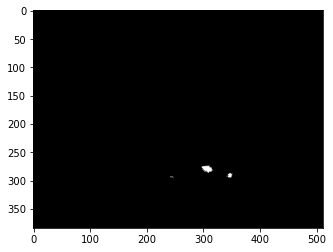

In [156]:
plt.imshow(np.argmax(pred_x_val[0].cpu().detach().numpy(), 0), cmap="gray")

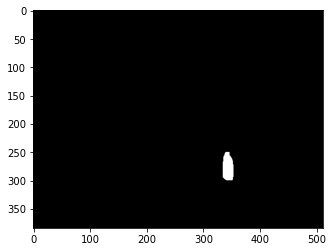

In [157]:
plt.imshow(batch_y_val[0], cmap="gray")

## simple network1 - fully_connected
#### pytorch

In [177]:
class Segmodel(nn.Module):
    def __init__(self, weight_shape):
        super(Segmodel, self).__init__()
        self.channel_zero_weight = nn.Parameter(torch.normal(torch.zeros(weight_shape), torch.ones(weight_shape)),\
                                            requires_grad=True)
        self.channel_one_weight = nn.Parameter(torch.normal(torch.zeros(weight_shape), torch.ones(weight_shape)),\
                                            requires_grad=True)
        self.channel_one_bias = nn.Parameter(torch.normal(torch.zeros(weight_shape), torch.ones(weight_shape)),\
                                            requires_grad=True)
        self.channel_two_bias = nn.Parameter(torch.normal(torch.zeros(weight_shape), torch.ones(weight_shape)),\
                                            requires_grad=True)
        self.scale = nn.Parameter(torch.tensor(10.0, requires_grad=True))


    def forward(self, x):
        channel_zero = x * self.channel_zero_weight/self.scale + self.channel_one_bias
        channel_zero = torch.unsqueeze(torch.sum(channel_zero, dim=1), 1)
        channel_one = x * self.channel_one_weight/self.scale + self.channel_two_bias
        channel_one = torch.unsqueeze(torch.sum(channel_one, dim=1), 1)
        return torch.cat([channel_zero, channel_one], 1)

In [179]:
weights_shape = (1, num_channels, img_height, img_width)
seg_net_fc  = Segmodel(weights_shape).to(device)

output_channels = 2
epochs = 5
bs = 9
learning_rate = 1e-1 
optimizer = torch.optim.Adam(seg_net_fc.parameters(), lr=learning_rate)
losses = []
train_x_paths = os.listdir(train_x)
val_x_paths = os.listdir(val_x)
for i in range(epochs):
    random.shuffle(train_x_paths)
    batch_losses = []
    iou_per_class = []
    iou_per_class_val = []
    len_paths = []
    for j in range(len(train_x_paths)//bs + 1):
        batch_paths = train_x_paths[j*bs: (j+1)*bs]
        len_paths.extend(batch_paths)
        batch_x = load_data(train_x, batch_paths)
        batch_x = torch.from_numpy(batch_x).to(device)
        batch_x = batch_x.permute((0, 3, 1, 2))
        batch_y = load_data(train_y, batch_paths)

        pred = seg_net_fc(batch_x).to(device)
        hot_batch_y = torch.from_numpy(one_hot_target(batch_y)).to(device)
        hot_batch_y.requires_grad = True
        pred = softmax(pred)
        loss = sparse_crossentropy(hot_batch_y, pred)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pred_x = seg_net_fc(batch_x).to(device)
        iou_per_class.append(calc_iou_per_class(pred_x, batch_y))
        batch_losses.append(loss.cpu().detach().numpy())
    
    for j in range(len(val_x_paths)//bs + 1):
        batch_paths = val_x_paths[j*bs: (j+1)*bs]
        batch_x_val = load_data(val_x, batch_paths)
        batch_x_val = np.expand_dims(batch_x_val, 0) if len(batch_x_val.shape) < 4 else batch_x_val
        batch_x_val = torch.from_numpy(batch_x_val).to(device)
        batch_x_val = batch_x_val.permute((0, 3, 1, 2))
        batch_y_val = load_data(val_y, batch_paths)
        pred_x_val = seg_net_fc(batch_x_val).to(device)
        iou_per_class_val.append(calc_iou_per_class(pred_x_val, batch_y_val))
    loss = sum(batch_losses)
    iou = np.mean(np.array(iou_per_class))
    iou_val = np.mean(np.array(iou_per_class_val))
    losses.append(loss)
    print(f"epoch {i}, loss: {loss}, iou_train: {iou}, iou_val: {iou_val}")

epoch 0, loss: 8.257838934659958, iou_train: 0.08067641321070726, iou_val: 0.084932022689442
epoch 1, loss: 4.189929217100143, iou_train: 0.19403491800350423, iou_val: 0.1629243658297867
epoch 2, loss: 2.6786985099315643, iou_train: 0.264402964788218, iou_val: 0.2102545662674725
epoch 3, loss: 1.9664382711052895, iou_train: 0.31082645039448736, iou_val: 0.23794137627295225
epoch 4, loss: 1.6234542429447174, iou_train: 0.3912580332420825, iou_val: 0.2568553063735863


In [182]:
per = list(seg_net_fc.parameters())

In [187]:
seg_net_fc.channel_zero_weight

Parameter containing:
tensor([[[[ 3.0015e-01, -1.2302e-01, -3.8226e-01,  ...,  1.9725e+00,
            9.0156e-01, -1.3470e+00],
          [-1.1552e+00, -4.9008e-01, -1.9597e+00,  ...,  1.0124e+00,
            1.2591e+00,  5.9483e-01],
          [ 1.5327e-01,  4.0144e-02, -1.4260e+00,  ..., -7.5145e-01,
            9.8270e-01,  8.0496e-01],
          ...,
          [ 6.8765e-01,  2.1178e+00, -1.6156e+00,  ...,  7.9265e-01,
            6.0856e-01,  3.6334e-01],
          [ 1.4248e+00,  2.5451e-01,  2.5929e-01,  ..., -7.0414e-01,
            7.5013e-01,  1.1645e+00],
          [ 3.2315e-01,  4.9604e-01, -6.1099e-01,  ..., -1.8292e-01,
           -1.3914e+00,  5.5048e-01]],

         [[ 2.1887e-01,  1.2473e-01, -1.4306e-01,  ...,  4.9489e-01,
           -2.3864e+00,  3.8603e-01],
          [ 1.8255e+00,  2.0318e-01,  1.4447e-01,  ...,  4.4164e-01,
           -7.6400e-02,  1.3516e-01],
          [-3.5701e-01,  2.9108e-02, -4.4440e-01,  ...,  2.6693e-01,
            1.7625e+00, -1.6868e+00]

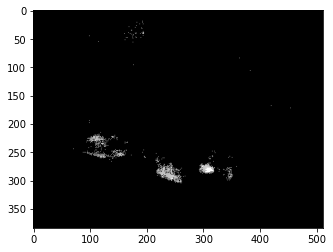

In [161]:
plt.imshow(np.argmax(pred_x_val[0].cpu().detach().numpy(), 0), cmap="gray")

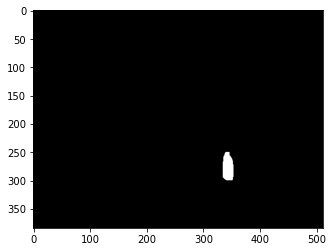

In [162]:
plt.imshow(batch_y_val[0], cmap="gray")

## conv3